In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load all accuracies
logreg_model = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/03-logistic-regression-results.csv")
dt_model = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-results.csv")
rf_model = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/results/05-random-forest-results.csv")
knn_model = pd.read_csv("/Users/Ingo/Python Files/Capstone Project/results/06-knn-results.csv")

# append all models to the logreg dataframe
results_df = logreg_model.append([dt_model, rf_model, knn_model], ignore_index = True)

# round values for better readability
results_df["test_accuracy"] = round(results_df["test_accuracy"], 2)

In [3]:
# load all recall scores

logreg_recall = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/03-logistic-regression-recall-results.csv")
dt_recall = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-recall-results.csv")
dt_recall_svd = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-svd-recall-results.csv")
rf_recall = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/05-random-forest-recall-results.csv")
knn_recall = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/06-knn-recall-results.csv")

# append all models to the logreg dataframe
recall_results_df = logreg_recall.append([dt_recall, dt_recall_svd, rf_recall, knn_recall],
                                         ignore_index = True, sort = False)

In [4]:
# load roc_df results
logreg_roc = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/03-logistic-regression-roc-results.csv")
dt_roc = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-roc-results.csv")
dt_svd_roc = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/04-decision-tree-svd-roc-results.csv")
rf_roc = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/05-random-forest-roc-results.csv")
knn_roc = pd.read_csv(
    "/Users/Ingo/Python Files/Capstone Project/results/06-knn-roc-results.csv")

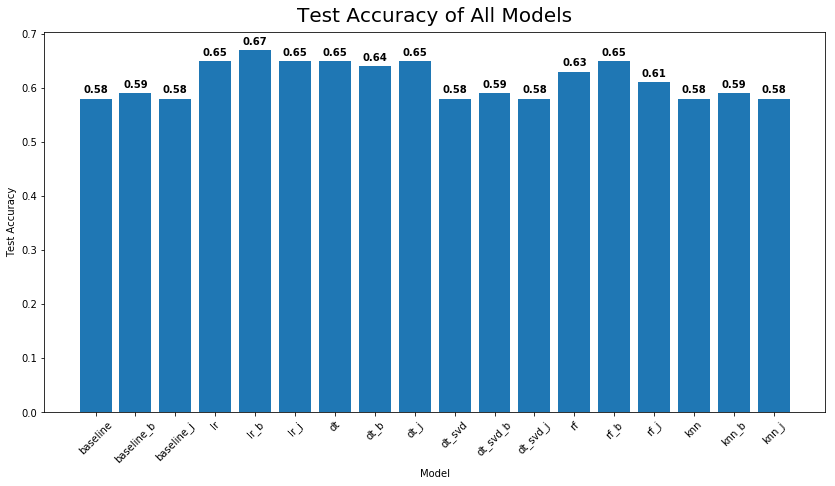

In [5]:
# bar plot of all results

# create x-coordinates
xcor = range(len(results_df))

plt.figure(figsize = (14, 7))
plt.bar(xcor, results_df["test_accuracy"])
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.xticks(ticks = xcor, labels = results_df["model"], rotation = 45)
plt.title("Test Accuracy of All Models", size = 20, y = 1.01)

# display test accuracy as text above bar charts
for bar, value in enumerate(results_df["test_accuracy"]):
    plt.text(bar, value + 0.01, # position text right above bars
             s = str(round(value, 2)), horizontalalignment = "center", fontweight = "bold")
    
plt.show()

This accuracy chart sums up what we saw in every separated model file:
* The logistic regression models were able to generalize best
* The dimensionality-reduced decision tree models as well as the dimensionality-reduced k-NN models mirror almost exactly the most-frequent baselines. Both models get so biased that they in some cases don't even predict certain classes once.
* Simple decision trees come in second, and random forests come in third place

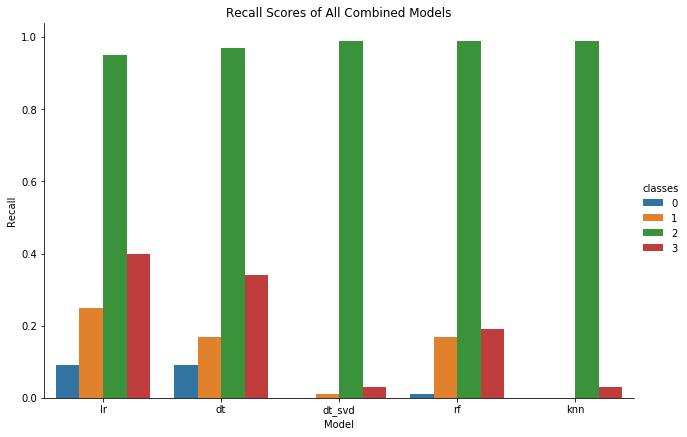

In [6]:
# bar plot of recall scores

recall_results_df["model"] = ["lr", "lr", "lr", "lr", "dt", "dt", "dt", "dt", "dt_svd", "dt_svd",
                             "dt_svd", "dt_svd", "rf", "rf", "rf", "rf", "knn", "knn", "knn", "knn"]

# group by model and plot results
sns.catplot(x = "model", y = "recall", hue = "classes", data = recall_results_df, kind = "bar",
           height = 6, aspect = 1.5)
plt.title("Recall Scores of All Combined Models")
plt.xlabel("Model")
plt.ylabel("Recall")
plt.show()

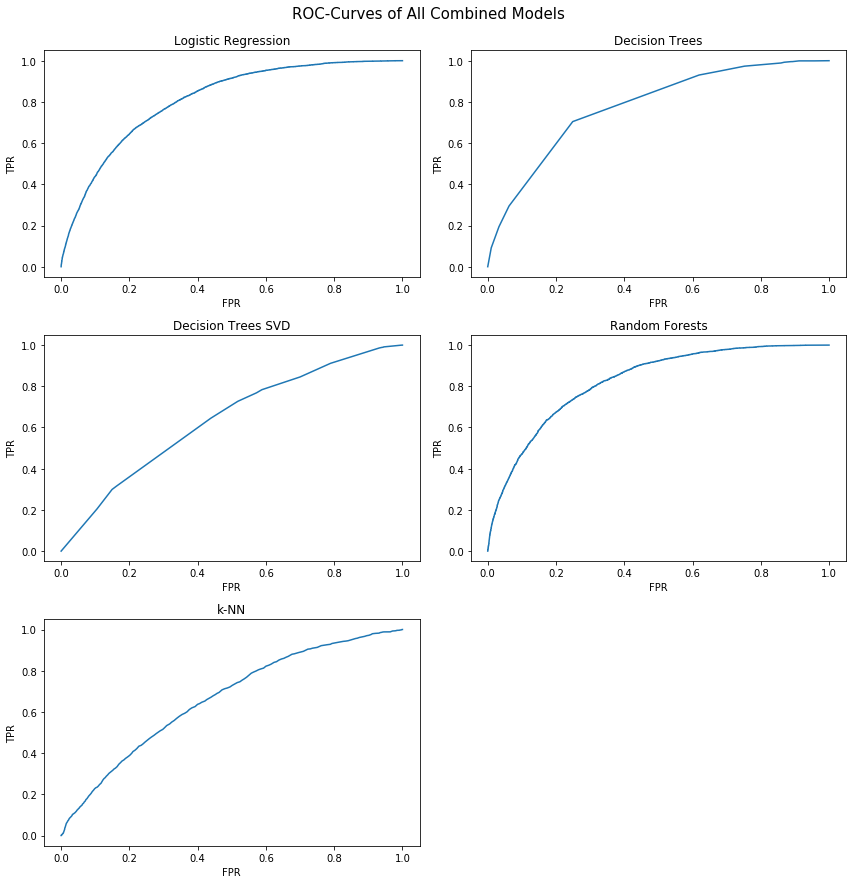

In [7]:
# plot all roc curves

# group all dfs
to_plot = [logreg_roc, dt_roc, dt_svd_roc, rf_roc, knn_roc]

# group titles
titles = ["Logistic Regression", "Decision Trees", "Decision Trees SVD", "Random Forests", "k-NN"]

fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 12))

for ax, plot, title in zip(axs.flat, to_plot, titles):
    ax.plot(plot["fpr"], plot["tpr"])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(title)

fig.delaxes(axs[2, 1])
plt.tight_layout() # avoids overlapping labels
plt.suptitle("ROC-Curves of All Combined Models", y = 1.02, size = 15)
plt.show()

### Final Discussion
In the logistic regression file, the probabilities of the invented `Student3` show that the model can't recognize a student with all the marks `Distinction`-finishing student had that we saw during EDA. That case, however, was a false positive event in which we classified a `Distinction`-finishing student as `Fail` with overwhelming probability of ~78%. Nevertheless, all the recall scores above suggest that we - in the best case model - only recognize 9% of all actual positives for the `Fail` class. This is a much more impactful shortcoming of all our models. 

If, for instance, this was a readily available system at Open University in which students could enter all background data and presumed activity level, at best 9% of all students who would actually fail would get `Fail` as a prediction. At the same time, our model will generally not misclassify them as `Withdrawn` but instead as `Pass` as we saw in all confusion matrices. This rate of false negativity, even sometimes at 100% such as in the `dt_svd` model, is extremely worrisome because it is more important to notify failing students of their true result instead of passing or distinction-finishing students. At this aspect, our models falls completely short.

If we were to tune the model to the exemplified 85% TPR in all models (in the simplified binary scenario in which positive = `Fail`, negative = `Pass`), the ROC-curves shows that this would also result in a >50% FPR in nearly all models. At that rate, we would still "only" have 85% recall rate for class `Fail`, but also a majority of students would get classified as `Fail` even though they are nowhere near the point of failure. As a consequence, the whole system would may not be taken seriously at all. 

All in all, the models in their current form fail to capture all classes besides `Pass`.

### Possible Explanation for Model Bias
During EDA process, we could see that there is a lot of variation among the features and the target variable for all classes. There are, for instance, students who submitted their exams too late but still have `Pass` as a final result. In other cases, students with bad scores in one assessment still finished with `Distinction` overall. 

This is a problem due to the way the data is structured. We merged our data to reflect unique observations in order to keep as much depth as possible. A consequence of this structure is that there are multiple contradictory data points among our total pool, which ML algorithms can't differentiate among. As an example, the algorithm doesn't know whether one bad assessment is just one of many the student wrote. So when the observation says that a student with `score = 22` and low overall VLE activity finished with `Pass`, the model trains on this profile that students with such characteristics can finish with `Pass`. The model especially doesn't know that some observations belong together - it just calculates based on every observation-label pair. Because the true unique student-module `Pass` group already accounted for the majority of samples, all following sub-results - indepdently of how bad or good they are - also have `Pass` as their label. Therefore, the `Pass` group encompasses virtually all possible background, score, and activity combinations. As it is additionally the largest group, the model learns primarily on those examples.

The consequence is that the model develops a strong bias in favor of `Pass` and we thus receive almost exclusively predictions in favor of `Pass`. Because this one class has such an overhelming amount of input variability in terms of feature values, there is no pattern left to be recognized for that class as basically every input value can lead to `Pass`. This results directly in the problem that there are no significant trends and pattern left to be recognized and learned from for the other 3 classes, because again, the `Pass` class also covers every possibility. The final result is what we could then see in the confusion matrices, namely that `Fail`, `Withdrawn`, and `Distinction` rarely - if at all - get predicted.

### Avenues for Future Analysis

The following starting points can be considered for future research and analysis. They aim to change the current data structure that is used as input.

#### 1) Use weighted averages of score- and weight-variable
**Advantages/Chances:**
* We get a better, aggregated view of a student's performance
* Dimensionality would automatically be vastly reduced as there wouldn't be one-hot-encoded `id_assessment` columns
* There would be fewer noisy and contradictory observations as the data for all assessments would now be grouped into one observation

**Disadvantages/Risks:**

* We lose informational depth as there are no more specific assessments available to predict off of
* Students can only be assessed by presuming all their assessment scores as one weighted average

#### 2) Clean the pass-class more drastically
**Advantages/Chances:**
* By dropping outliers more strictly specifically for the `Pass` class, the hope is to force a certain, distinct pattern on the `Pass` input data
* Input data for `Pass` would thus be less encompassing and allow the other classes more room and recognition

**Disadvantages/Risks:**

* If the data in general is simply very spread out for the pass class, i.e. test data for pass would also be very messy, this would result in no explanatory power gain and instead more false classifications

#### 3) Change the final-results structure to binary
Here we would drop `Withdrawn` observations completely, change `Distinction` to `Pass`, and only differentiate between `Fail` and `Pass`

**Advantages/Chances:**
* The model now needs less nuance to discriminate among classes like `Withdrawn` which even humans would have problems to predict as it is not clear from EDA when and why a student would withdraw
* We could tune the recall score by changing thresholds as we are now in a binary setting where we don't need to mind interferences of all other classes

**Disadvantages/Risks:**
* We probably need to resample the data set as it would be very imbalanced
* This still wouldn't solve the problem of the all-encompassing `Pass` class, so we'd need to combine some of 1) and 2) here aswell